<a href="https://colab.research.google.com/github/datacentertugaskuliah-coder/PraktikumDS/blob/main/Simulasi_Reinforcement_Learning_dengan_Q_learning_untuk_Rekomendasi_Barang.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ukuran data awal: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


Ukuran data setelah prapemrosesan: (397884, 8)


,Tahap,Sebelum,Sesudah,Gugur
0,Hapus baris dengan nilai kosong pada kolom wajib,541909,406829,135080
1,Hapus transaksi pembatalan (InvoiceNo diawali C),406829,397924,8905
2,Saring pembelian valid (Quantity>0 dan UnitPri...,397924,397884,40
3,Validasi CustomerID numerik,397884,397884,0


Jumlah keranjang valid: 18562


,CustomerID,InvoiceNo,InvoiceDate,BasketItems,NilaiKeranjang
0,12346,541431,2011-01-18 10:01:00,[23166],77183.60
1,12347,537626,2010-12-07 14:57:00,"[20780, 20782, 21064, 21171, 21731, 22195, 222...",711.79
2,12347,542237,2011-01-26 14:30:00,"[20719, 20966, 21035, 21041, 21154, 21731, 218...",475.39
3,12347,549222,2011-04-07 10:43:00,"[16008, 20665, 21041, 21731, 21791, 21975, 221...",636.25
4,12347,556201,2011-06-09 13:01:00,"[17021, 22196, 22371, 22375, 22725, 22727, 230...",382.52


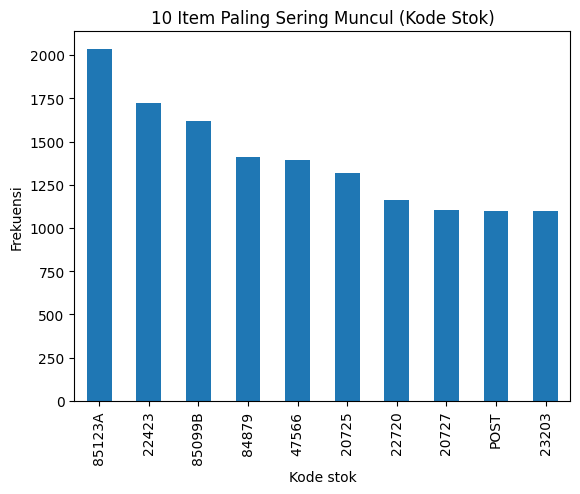

Jumlah episode (pelanggan dengan minimal 2 keranjang): 2847
Pelanggan latih: 2277 | Pelanggan uji: 570
Epoch 1/10 | Reward latih/step: 0.0012 | Reward uji/step: -0.0170 | Hit uji: 0.1149 | Hit baseline: 0.0926 | Epsilon: 0.995 | Jumlah state: 9727
Epoch 2/10 | Reward latih/step: 0.0007 | Reward uji/step: -0.0160 | Hit uji: 0.1072 | Hit baseline: 0.0926 | Epsilon: 0.990 | Jumlah state: 9727
Epoch 3/10 | Reward latih/step: 0.0008 | Reward uji/step: -0.0155 | Hit uji: 0.1110 | Hit baseline: 0.0926 | Epsilon: 0.985 | Jumlah state: 9727
Epoch 4/10 | Reward latih/step: 0.0028 | Reward uji/step: -0.0159 | Hit uji: 0.1072 | Hit baseline: 0.0926 | Epsilon: 0.980 | Jumlah state: 9727
Epoch 5/10 | Reward latih/step: 0.0020 | Reward uji/step: -0.0151 | Hit uji: 0.1129 | Hit baseline: 0.0926 | Epsilon: 0.975 | Jumlah state: 9727
Epoch 6/10 | Reward latih/step: 0.0014 | Reward uji/step: -0.0161 | Hit uji: 0.1057 | Hit baseline: 0.0926 | Epsilon: 0.970 | Jumlah state: 9727
Epoch 7/10 | Reward latih/s

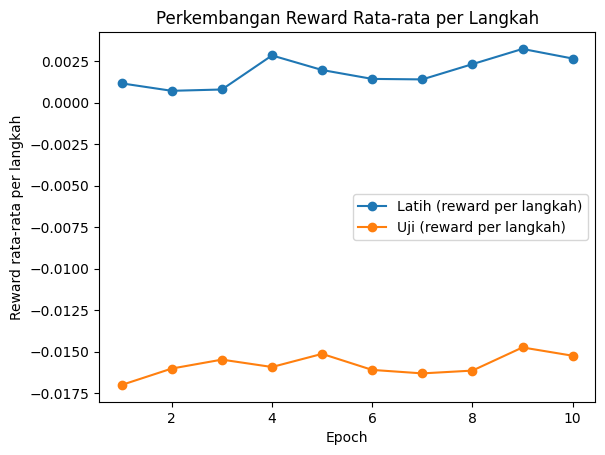

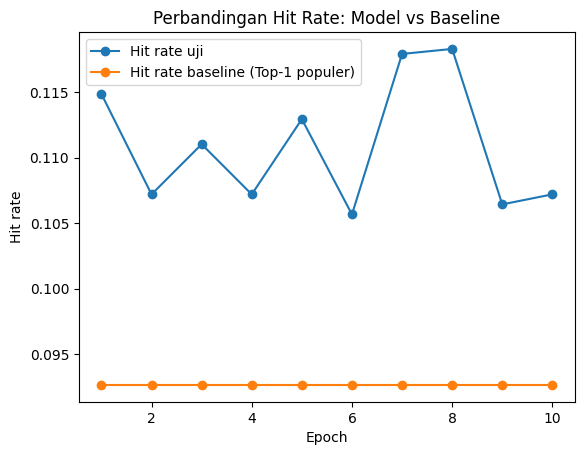

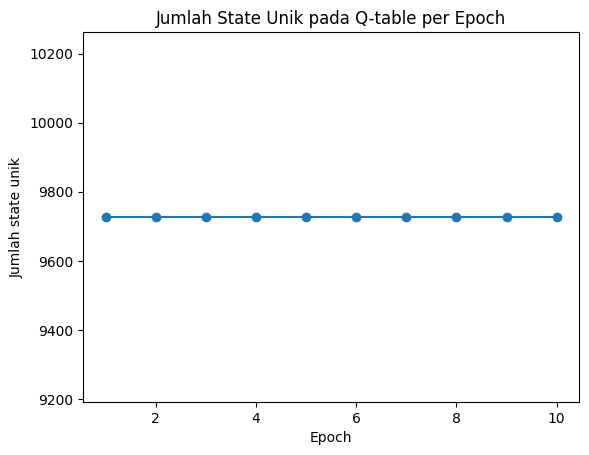

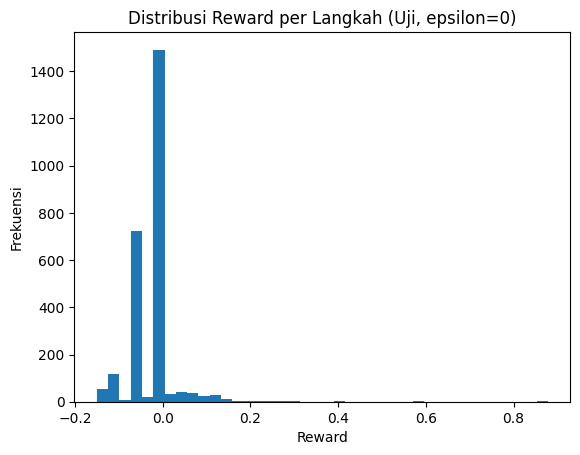

,Metrik,Nilai
0,Reward rata-rata per episode,-0.012512
1,Reward rata-rata per langkah,-0.015242
2,Hit rate,0.107198
3,Cakupan rekomendasi,0.860000
4,Rasio repetisi,0.325421
5,Baseline reward rata-rata per langkah,-0.051108
6,Baseline hit rate,0.092649
7,Jumlah langkah,2612.000000


,Metrik,Nilai
0,Pelanggan dengan minimal 2 keranjang,2847
1,Jumlah pelanggan latih,2277
2,Jumlah pelanggan uji,570
3,Ukuran ruang aksi K,50
4,Ukuran token eksplisit M,200
5,Jumlah state unik Q-table (akhir),9727
6,Epsilon akhir,0.95111
7,Baseline item (Top-1 populer),85123A


In [3]:
# ==========================================================
# Praktikum Data Science dan Machine Learning Berbasis Python dan UCI Repository
# Pembahasan: Simulasi Reinforcement Learning dengan Q-learning untuk Rekomendasi Barang
# Dataset: Online Retail (UCI Machine Learning Repository, id=352)
# Repo: https://github.com/datacentertugaskuliah-coder/PraktikumDS.git
# Lingkungan: Google Colab
# ==========================================================

!pip -q install ucimlrepo openpyxl

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from ucimlrepo import fetch_ucirepo

# ----------------------------------------------------------
# 0) Pengaturan awal untuk memastikan hasil dapat direplikasi
# ----------------------------------------------------------
SEED = 42
rng = np.random.default_rng(SEED)
np.random.seed(SEED)

# ----------------------------------------------------------
# 1) Akuisisi data dari UCI Repository (id=352)
#    Gunakan data.original agar kolom ID (InvoiceNo, StockCode) ikut tersedia.
# ----------------------------------------------------------
online_retail = fetch_ucirepo(id=352)

df = getattr(online_retail.data, "original", None)
if df is None:
    ids = getattr(online_retail.data, "ids", None)
    feats = getattr(online_retail.data, "features", None)
    if ids is not None and feats is not None:
        df = pd.concat([ids, feats], axis=1)
    elif feats is not None:
        df = feats.copy()
    else:
        raise ValueError("Sumber data tidak tersedia pada objek dataset (original, ids, features).")

df = df.copy()
df.columns = df.columns.astype(str).str.strip().str.replace(" ", "", regex=False)

print("Ukuran data awal:", df.shape)
display(df.head())

# ----------------------------------------------------------
# 2) Validasi kolom wajib
# ----------------------------------------------------------
kolom_wajib = ["CustomerID", "InvoiceNo", "StockCode", "InvoiceDate", "UnitPrice", "Quantity"]
kolom_hilang = [k for k in kolom_wajib if k not in df.columns]
if kolom_hilang:
    raise ValueError(f"Kolom wajib tidak ditemukan: {kolom_hilang}. Kolom tersedia: {list(df.columns)}")

# ----------------------------------------------------------
# 3) Prapemrosesan data dengan audit jumlah baris (transparansi)
# ----------------------------------------------------------
audit = []

def catat(tahap, sebelum, sesudah):
    audit.append({"Tahap": tahap, "Sebelum": int(sebelum), "Sesudah": int(sesudah), "Gugur": int(sebelum - sesudah)})

n0 = len(df)
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], errors="coerce")
df = df.dropna(subset=kolom_wajib)
catat("Hapus baris dengan nilai kosong pada kolom wajib", n0, len(df))

n0 = len(df)
df = df[~df["InvoiceNo"].astype(str).str.startswith("C")]
catat("Hapus transaksi pembatalan (InvoiceNo diawali C)", n0, len(df))

n0 = len(df)
df["Quantity"] = pd.to_numeric(df["Quantity"], errors="coerce")
df["UnitPrice"] = pd.to_numeric(df["UnitPrice"], errors="coerce")
df = df.dropna(subset=["Quantity", "UnitPrice"])
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]
catat("Saring pembelian valid (Quantity>0 dan UnitPrice>0)", n0, len(df))

n0 = len(df)
df["CustomerID"] = pd.to_numeric(df["CustomerID"], errors="coerce")
df = df.dropna(subset=["CustomerID"])
df["CustomerID"] = df["CustomerID"].astype(int)
catat("Validasi CustomerID numerik", n0, len(df))

df["StockCode"] = df["StockCode"].astype(str)
df["InvoiceNo"] = df["InvoiceNo"].astype(str)

df = df.sort_values(["CustomerID", "InvoiceDate", "InvoiceNo"]).reset_index(drop=True)

print("Ukuran data setelah prapemrosesan:", df.shape)
display(pd.DataFrame(audit))

# ----------------------------------------------------------
# 4) Pembentukan keranjang belanja per invoice
#    Catatan: urutan item dalam keranjang tidak dianggap urutan preferensi.
# ----------------------------------------------------------
basket_df = (
    df.groupby(["CustomerID", "InvoiceNo", "InvoiceDate"])
      .agg(BasketItems=("StockCode", lambda x: sorted(set(x.astype(str)))))
      .reset_index()
)

value_df = (
    df.assign(NilaiBaris=df["UnitPrice"] * df["Quantity"])
      .groupby(["CustomerID", "InvoiceNo", "InvoiceDate"])["NilaiBaris"]
      .sum()
      .reset_index()
      .rename(columns={"NilaiBaris": "NilaiKeranjang"})
)

basket_df = basket_df.merge(value_df, on=["CustomerID", "InvoiceNo", "InvoiceDate"], how="left")
basket_df = basket_df.sort_values(["CustomerID", "InvoiceDate", "InvoiceNo"]).reset_index(drop=True)

print("Jumlah keranjang valid:", len(basket_df))
display(basket_df.head())

# ----------------------------------------------------------
# 5) Analisis deskriptif singkat untuk ruang aksi
# ----------------------------------------------------------
item_counts = df["StockCode"].value_counts()

plt.figure()
item_counts.head(10).plot(kind="bar")
plt.title("10 Item Paling Sering Muncul (Kode Stok)")
plt.xlabel("Kode stok")
plt.ylabel("Frekuensi")
plt.show()

# ----------------------------------------------------------
# 6) Pembentukan episode dan pembagian data latih-uji (berbasis pelanggan)
# ----------------------------------------------------------
episodes = {}
for cid, sub in basket_df.groupby("CustomerID"):
    seq_items = sub["BasketItems"].tolist()
    seq_val = sub["NilaiKeranjang"].tolist()
    if len(seq_items) >= 2:
        episodes[cid] = list(zip(seq_items, seq_val))

all_customers = np.array(list(episodes.keys()))
rng.shuffle(all_customers)

rasio_uji = 0.2
batas = int(len(all_customers) * (1 - rasio_uji))
pelanggan_latih = set(all_customers[:batas])
pelanggan_uji = set(all_customers[batas:])

print("Jumlah episode (pelanggan dengan minimal 2 keranjang):", len(episodes))
print("Pelanggan latih:", len(pelanggan_latih), "| Pelanggan uji:", len(pelanggan_uji))

# ----------------------------------------------------------
# 7) Ruang aksi dan ko-kemunculan
# ----------------------------------------------------------
K = 50
ACTIONS = list(item_counts.head(K).index)
action_to_idx = {a: i for i, a in enumerate(ACTIONS)}

cooc = defaultdict(Counter)
for items in basket_df["BasketItems"]:
    items_set = [it for it in items if it in action_to_idx]
    for i in items_set:
        for j in items_set:
            if i != j:
                cooc[i][j] += 1

def ranked_candidates_from_state_items(state_items, max_cand=15):
    # Abaikan token non-item agar kandidat tidak bias atau kosong
    state_items = [it for it in state_items if it not in ("KOSONG", "LAINNYA")]
    merged = Counter()
    for it in state_items:
        if it in cooc:
            merged.update(cooc[it])

    if not merged:
        return ACTIONS[:max_cand]

    ranked = [it for it, _ in merged.most_common() if it in action_to_idx]

    out = []
    for it in ranked:
        if it not in out:
            out.append(it)
        if len(out) >= max_cand:
            break

    for it in ACTIONS:
        if len(out) >= max_cand:
            break
        if it not in out:
            out.append(it)

    return out

# ----------------------------------------------------------
# 8) Perancangan state yang lebih stabil: ringkasan histori keranjang
#    Strategi: ambil item dari beberapa keranjang terakhir, lalu pilih 3 item teratas berdasarkan frekuensi.
# ----------------------------------------------------------
M = 200
TOP_M = set(item_counts.head(M).index)

def compress_item(it):
    return it if it in TOP_M else "LAINNYA"

def get_state(history_items, jendela_keranjang=3, n_token=3):
    # history_items berisi list keranjang sebelumnya (bukan termasuk keranjang saat ini)
    recent = history_items[-jendela_keranjang:] if len(history_items) >= 1 else []
    cnt = Counter()
    for b in recent:
        for it in b:
            cnt[compress_item(it)] += 1

    # Ambil token paling sering, prioritaskan item nyata dibanding "LAINNYA"
    tokens = []
    for it, _ in cnt.most_common():
        if it == "LAINNYA":
            continue
        tokens.append(it)
        if len(tokens) >= n_token:
            break

    # Jika kurang token, isi dari "LAINNYA" bila ada frekuensinya, lalu pad KOSONG
    if len(tokens) < n_token and cnt.get("LAINNYA", 0) > 0:
        tokens.append("LAINNYA")

    while len(tokens) < n_token:
        tokens.append("KOSONG")

    return "|".join(tokens[:n_token])

def parse_state_to_items(state_str):
    return [x for x in state_str.split("|") if x not in ("KOSONG",)]

# ----------------------------------------------------------
# 9) Perancangan reward + baseline pembanding
# ----------------------------------------------------------
pop = item_counts.to_dict()

def inv_pop_weight(item):
    c = pop.get(item, 1)
    return 1.0 / np.sqrt(c)

penalti_ulang = 0.05
penalti_sudah_ada = 0.10

all_values = basket_df["NilaiKeranjang"].fillna(0).values
p95 = np.percentile(all_values, 95) if len(all_values) else 1.0
skala_nilai = p95 if p95 > 0 else 1.0

def compute_reward(item_rekomendasi, keranjang_saat_ini, keranjang_berikutnya, nilai_berikutnya, aksi_sebelumnya):
    r = 0.0
    kena = (item_rekomendasi in keranjang_berikutnya)

    if kena:
        r += 1.0 * inv_pop_weight(item_rekomendasi)
        r += 0.2 * (float(nilai_berikutnya) / skala_nilai)

    if item_rekomendasi in keranjang_saat_ini:
        r -= penalti_sudah_ada

    if aksi_sebelumnya is not None and item_rekomendasi == aksi_sebelumnya:
        r -= penalti_ulang

    return r, int(kena)

# Baseline: selalu rekomendasikan item paling populer (Top-1)
baseline_item = ACTIONS[0]

# ----------------------------------------------------------
# 10) Q-learning dan fungsi evaluasi metrik
# ----------------------------------------------------------
alpha = 0.2
gamma = 0.9

epsilon = 1.0
eps_min = 0.05
eps_decay = 0.995

Q = defaultdict(lambda: np.zeros(len(ACTIONS), dtype=np.float32))

def choose_action(state, eps):
    state_items = parse_state_to_items(state)
    cands = ranked_candidates_from_state_items(state_items, max_cand=15)
    cand_idx = [action_to_idx[x] for x in cands if x in action_to_idx]
    if len(cand_idx) == 0:
        cand_idx = list(range(len(ACTIONS)))

    if rng.random() < eps:
        return int(rng.choice(cand_idx))

    qvals = Q[state][cand_idx]
    return int(cand_idx[int(np.argmax(qvals))])

def run_epoch(customers, train_mode=True, eps=0.0, hit_only=False):
    total_rewards = []
    step_rewards = []
    hits = 0
    steps = 0
    rekom_set = set()
    repetisi = 0
    prev_action_item_global = None

    baseline_hits = 0
    baseline_steps = 0
    baseline_rewards = []

    for cid in customers:
        seq = episodes[cid]
        history = []
        aksi_sebelumnya = None
        reward_episode = 0.0
        prev_action_item = None

        for t in range(len(seq) - 1):
            keranjang_saat_ini, _ = seq[t]
            keranjang_berikutnya, nilai_berikutnya = seq[t + 1]

            # state dibentuk dari histori sebelum keranjang saat ini
            s = get_state(history, jendela_keranjang=3, n_token=3)

            # update histori setelah state terbentuk (supaya definisi state konsisten)
            history.append(keranjang_saat_ini)

            s_next = get_state(history, jendela_keranjang=3, n_token=3)

            # pilih aksi
            a_idx = choose_action(s, eps if train_mode else 0.0)
            item_rekomendasi = ACTIONS[a_idx]

            r, hit = compute_reward(item_rekomendasi, keranjang_saat_ini, keranjang_berikutnya, nilai_berikutnya, aksi_sebelumnya)

            if train_mode:
                td_target = r + gamma * float(np.max(Q[s_next]))
                Q[s][a_idx] += alpha * (td_target - Q[s][a_idx])

            reward_episode += r
            total_rewards.append(0.0)  # placeholder per step, akan diringkas per episode di bawah
            step_rewards.append(r)

            hits += hit
            steps += 1

            rekom_set.add(item_rekomendasi)
            if prev_action_item is not None and item_rekomendasi == prev_action_item:
                repetisi += 1
            prev_action_item = item_rekomendasi
            aksi_sebelumnya = item_rekomendasi

            # baseline per step
            br, bhit = compute_reward(baseline_item, keranjang_saat_ini, keranjang_berikutnya, nilai_berikutnya, prev_action_item_global)
            baseline_rewards.append(br)
            baseline_hits += bhit
            baseline_steps += 1
            prev_action_item_global = baseline_item

        total_rewards.append(reward_episode)

    avg_episode_reward = float(np.mean(total_rewards)) if total_rewards else 0.0
    avg_step_reward = float(np.mean(step_rewards)) if step_rewards else 0.0
    hit_rate = float(hits / steps) if steps else 0.0
    cakupan = float(len(rekom_set) / len(ACTIONS)) if ACTIONS else 0.0
    rasio_repetisi = float(repetisi / steps) if steps else 0.0

    baseline_avg_step_reward = float(np.mean(baseline_rewards)) if baseline_rewards else 0.0
    baseline_hit_rate = float(baseline_hits / baseline_steps) if baseline_steps else 0.0

    metrik = {
        "Reward rata-rata per episode": avg_episode_reward,
        "Reward rata-rata per langkah": avg_step_reward,
        "Hit rate": hit_rate,
        "Cakupan rekomendasi": cakupan,
        "Rasio repetisi": rasio_repetisi,
        "Baseline reward rata-rata per langkah": baseline_avg_step_reward,
        "Baseline hit rate": baseline_hit_rate,
        "Jumlah langkah": steps
    }

    return metrik, np.array(step_rewards, dtype=float)

# ----------------------------------------------------------
# 11) Pelatihan dan evaluasi per epoch (dengan baseline dan metrik)
# ----------------------------------------------------------
num_epochs = 10
kurva_reward_latih = []
kurva_reward_uji = []
kurva_hit_uji = []
kurva_hit_baseline = []
kurva_state = []

daftar_latih = list(pelanggan_latih)
daftar_uji = list(pelanggan_uji)

for epoch in range(1, num_epochs + 1):
    rng.shuffle(daftar_latih)

    metrik_latih, _ = run_epoch(daftar_latih, train_mode=True, eps=epsilon)
    metrik_uji, _ = run_epoch(daftar_uji, train_mode=False, eps=0.0)

    kurva_reward_latih.append(metrik_latih["Reward rata-rata per langkah"])
    kurva_reward_uji.append(metrik_uji["Reward rata-rata per langkah"])
    kurva_hit_uji.append(metrik_uji["Hit rate"])
    kurva_hit_baseline.append(metrik_uji["Baseline hit rate"])
    kurva_state.append(len(Q))

    epsilon = max(eps_min, epsilon * eps_decay)

    print(
        f"Epoch {epoch}/{num_epochs} | "
        f"Reward latih/step: {metrik_latih['Reward rata-rata per langkah']:.4f} | "
        f"Reward uji/step: {metrik_uji['Reward rata-rata per langkah']:.4f} | "
        f"Hit uji: {metrik_uji['Hit rate']:.4f} | "
        f"Hit baseline: {metrik_uji['Baseline hit rate']:.4f} | "
        f"Epsilon: {epsilon:.3f} | "
        f"Jumlah state: {len(Q)}"
    )

# ----------------------------------------------------------
# 12) Visualisasi kurva pembelajaran dan pembanding baseline
# ----------------------------------------------------------
plt.figure()
plt.plot(range(1, num_epochs + 1), kurva_reward_latih, marker="o", label="Latih (reward per langkah)")
plt.plot(range(1, num_epochs + 1), kurva_reward_uji, marker="o", label="Uji (reward per langkah)")
plt.title("Perkembangan Reward Rata-rata per Langkah")
plt.xlabel("Epoch")
plt.ylabel("Reward rata-rata per langkah")
plt.legend()
plt.show()

plt.figure()
plt.plot(range(1, num_epochs + 1), kurva_hit_uji, marker="o", label="Hit rate uji")
plt.plot(range(1, num_epochs + 1), kurva_hit_baseline, marker="o", label="Hit rate baseline (Top-1 populer)")
plt.title("Perbandingan Hit Rate: Model vs Baseline")
plt.xlabel("Epoch")
plt.ylabel("Hit rate")
plt.legend()
plt.show()

plt.figure()
plt.plot(range(1, num_epochs + 1), kurva_state, marker="o")
plt.title("Jumlah State Unik pada Q-table per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Jumlah state unik")
plt.show()

# ----------------------------------------------------------
# 13) Distribusi reward per langkah (uiji, epsilon=0)
# ----------------------------------------------------------
metrik_uji_final, reward_langkah_uji = run_epoch(daftar_uji, train_mode=False, eps=0.0)

plt.figure()
plt.hist(reward_langkah_uji, bins=40)
plt.title("Distribusi Reward per Langkah (Uji, epsilon=0)")
plt.xlabel("Reward")
plt.ylabel("Frekuensi")
plt.show()

# ----------------------------------------------------------
# 14) Ringkasan metrik akhir (uiji)
# ----------------------------------------------------------
ringkasan_metrik = pd.DataFrame([metrik_uji_final]).T.reset_index()
ringkasan_metrik.columns = ["Metrik", "Nilai"]
display(ringkasan_metrik)

# ----------------------------------------------------------
# 15) Ringkasan indikator konfigurasi
# ----------------------------------------------------------
ringkasan_konfig = pd.DataFrame({
    "Metrik": [
        "Pelanggan dengan minimal 2 keranjang",
        "Jumlah pelanggan latih",
        "Jumlah pelanggan uji",
        "Ukuran ruang aksi K",
        "Ukuran token eksplisit M",
        "Jumlah state unik Q-table (akhir)",
        "Epsilon akhir",
        "Baseline item (Top-1 populer)"
    ],
    "Nilai": [
        len(episodes),
        len(pelanggan_latih),
        len(pelanggan_uji),
        K,
        M,
        len(Q),
        epsilon,
        baseline_item
    ]
})
display(ringkasan_konfig)
